Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


### CHECK CHANGES BELOW 

In [13]:
from random import random
from math import ceil
from functools import reduce
from collections import namedtuple, deque
from queue import PriorityQueue

import numpy as np
from tqdm.auto import tqdm

In [71]:
State = namedtuple('State', ['taken', 'not_taken'])


def covered(state):
    return reduce(
        np.logical_or,
        [SETS[i] for i in state.taken],
        np.array([False for _ in range(PROBLEM_SIZE)]),
    )


def goal_check(state):
    return np.all(covered(state))

In [54]:
PROBLEM_SIZE = 10
NUM_SETS = 25
SETS = tuple(np.array([random() < 0.2 for _ in range(PROBLEM_SIZE)]) for _ in range(NUM_SETS))
assert goal_check(State(set(range(NUM_SETS)), set())), "Problem not solvable"

In [55]:
# OUR DATA
for i, s in enumerate(SETS):
    print(f"Set {i}: {s}")

Set 0: [False False False False False False False False  True False]
Set 1: [False  True  True False False  True False False False False]
Set 2: [False False False False False False False False False False]
Set 3: [False False False False  True  True False False False False]
Set 4: [False False False False False False False False False False]
Set 5: [ True False False  True False  True False  True False  True]
Set 6: [ True False False  True  True False False False False False]
Set 7: [False  True False False False False False  True False False]
Set 8: [False False False False False False False False False False]
Set 9: [False  True  True False False False  True  True  True False]
Set 10: [False False  True False False False False False False False]
Set 11: [False False False False False False  True False False False]
Set 12: [False False  True False False False False False False False]
Set 13: [False False False False False False  True False False  True]
Set 14: [False False  True Fal

## Depth First

In [57]:
frontier = deque()
state = State(set(), set(range(NUM_SETS)))
frontier.append(state)

counter = 0
current_state = frontier.pop()
with tqdm(total=None) as pbar:
    while not goal_check(current_state):
        counter += 1
        for action in current_state[1]:
            new_state = State(
                current_state.taken ^ {action},
                current_state.not_taken ^ {action},
            )
            frontier.append(new_state)
        current_state = frontier.pop()
        pbar.update(1)

print(f"Solved in {counter:,} steps ({len(current_state.taken)} tiles)")
print(current_state.taken)
# for i in current_state.taken:
#     print(SETS[i])

8it [00:00, 7970.17it/s]

Solved in 8 steps (8 tiles)
{17, 18, 19, 20, 21, 22, 23, 24}


## Breadth First

In [58]:
frontier = deque()
state = State(set(), set(range(NUM_SETS)))
frontier.append(state)

counter = 0
current_state = frontier.popleft()
with tqdm(total=None) as pbar:
    while not goal_check(current_state):
        counter += 1
        for action in current_state[1]:
            new_state = State(
                current_state.taken ^ {action},
                current_state.not_taken ^ {action},
            )
            frontier.append(new_state)
        current_state = frontier.popleft()
        pbar.update(1)

print(f"Solved in {counter:,} steps ({len(current_state.taken)} tiles)")
print(current_state.taken)
# for i in current_state.taken:
#     print(SETS[i])

1284it [00:00, 6478.59it/s]

Solved in 1,284 steps (3 tiles)
{16, 1, 5}


## Greedy Best First

In [59]:
def f(state):
    missing_size = PROBLEM_SIZE - sum(covered(state))
    return missing_size

In [60]:
frontier = PriorityQueue()
state = State(set(), set(range(NUM_SETS)))
frontier.put((f(state), state))

counter = 0
_, current_state = frontier.get()
with tqdm(total=None) as pbar:
    while not goal_check(current_state):
        counter += 1
        for action in current_state[1]:
            new_state = State(
                current_state.taken ^ {action},
                current_state.not_taken ^ {action},
            )
            frontier.put((f(new_state), new_state))
        _, current_state = frontier.get()
        pbar.update(1)

print(f"Solved in {counter:,} steps ({len(current_state.taken)} tiles)")
print(current_state.taken)
# for i in current_state.taken:
#     print(SETS[i])

3it [00:00, 1494.59it/s]

Solved in 3 steps (3 tiles)
{9, 3, 5}


### Greedy with more sophisticated heuristic function
1. Partially Covered Sets: It calculates the number of sets that partially cover the remaining uncovered elements. This can guide the search towards states that are more likely to lead to a solution.

2. Combined Heuristic: Combine this with the existing 'missing size' to get a more informed heuristic. For example, the heuristic could be a weighted sum of the missing size and the number of partially covering sets.

In [61]:
weight_factor = 1
def enhanced_heuristic(state, weight_factor):
    covered_elements = covered(state)
    uncovered_elements = ~covered_elements
    partially_covered_sets = sum(np.logical_and(SETS[i], uncovered_elements).any() for i in state.not_taken)

    missing_size = PROBLEM_SIZE - sum(covered_elements)
    return missing_size + partially_covered_sets * weight_factor  # weight_factor to be determined

In [62]:
frontier = PriorityQueue()
state = State(set(), set(range(NUM_SETS)))
frontier.put((enhanced_heuristic(state, weight_factor), state))

counter = 0
_, current_state = frontier.get()
with tqdm(total=None) as pbar:
    while not goal_check(current_state):
        counter += 1
        for action in current_state[1]:
            new_state = State(
                current_state.taken ^ {action},
                current_state.not_taken ^ {action},
            )
            frontier.put((enhanced_heuristic(new_state, weight_factor), new_state))
        _, current_state = frontier.get()
        pbar.update(1)

print(f"Solved in {counter:,} steps ({len(current_state.taken)} tiles)")
print(current_state.taken)
# for i in current_state.taken:
#     print(SETS[i])

3it [00:00, 428.44it/s]

Solved in 3 steps (3 tiles)
{9, 3, 5}


Enhancing with partially covering sets outperforms when problem size is large (test it if you don't trust me)

### Pruning Redundant Paths
To avoid exploring redundant paths, we can keep track of states that have already been visited.

1. Visited States: Maintain a set of visited states.
2. Check Before Adding to Frontier: Before adding a new state to the frontier, check if it has been visited. If it has, skip adding it.

In [64]:
wf = 2.3
visited_states = set()
frontier = PriorityQueue()
# transform sets to immutable sets
state = State(frozenset(), frozenset(range(NUM_SETS)))
frontier.put((enhanced_heuristic(state, wf), state))

counter = 0
_, current_state = frontier.get()
with tqdm(total=None) as pbar:
    while not goal_check(current_state):
        counter += 1
        for action in current_state[1]:
            # make it immutable
            new_state = State(
                frozenset(current_state.taken ^ {action}),
                frozenset(current_state.not_taken ^ {action}),
            )
            # check if we have visited this state before
            # this line won't work unless we use immutable sets
            if new_state not in visited_states:
                visited_states.add(new_state)
                frontier.put((enhanced_heuristic(new_state, wf), new_state))
        _, current_state = frontier.get()
        pbar.update(1)

print(current_state.taken)
print(f"Solved in {counter:,} steps ({len(current_state.taken)} tiles)")

3it [00:00, 374.59it/s]

frozenset({9, 3, 5})
Solved in 3 steps (3 tiles)


## A*

In [65]:
def h(state):
    largest_set_size = max(sum(s) for s in SETS)
    missing_size = PROBLEM_SIZE - sum(covered(state))
    optimistic_estimate = ceil(missing_size / largest_set_size)
    return optimistic_estimate


def h2(state):
    already_covered = covered(state)
    if np.all(already_covered):
        return 0
    largest_set_size = max(sum(np.logical_and(s, np.logical_not(already_covered))) for s in SETS)
    missing_size = PROBLEM_SIZE - sum(already_covered)
    optimistic_estimate = ceil(missing_size / largest_set_size)
    return optimistic_estimate


def h3(state):
    already_covered = covered(state)
    if np.all(already_covered):
        return 0
    missing_size = PROBLEM_SIZE - sum(already_covered)
    candidates = sorted((sum(np.logical_and(s, np.logical_not(already_covered))) for s in SETS), reverse=True)
    taken = 1
    while sum(candidates[:taken]) < missing_size:
        taken += 1
    return taken


def f(state):
    return len(state.taken) + h3(state)

In [66]:
frontier = PriorityQueue()
state = State(set(), set(range(NUM_SETS)))
frontier.put((f(state), state))

counter = 0
_, current_state = frontier.get()
with tqdm(total=None) as pbar:
    while not goal_check(current_state):
        counter += 1
        for action in current_state[1]:
            new_state = State(
                current_state.taken ^ {action},
                current_state.not_taken ^ {action},
            )
            frontier.put((f(new_state), new_state))
        _, current_state = frontier.get()
        pbar.update(1)
        
print(current_state.taken)
print(f"Solved in {counter:,} steps ({len(current_state.taken)} tiles)")

13it [00:00, 232.10it/s]

{16, 5, 14}
Solved in 13 steps (3 tiles)


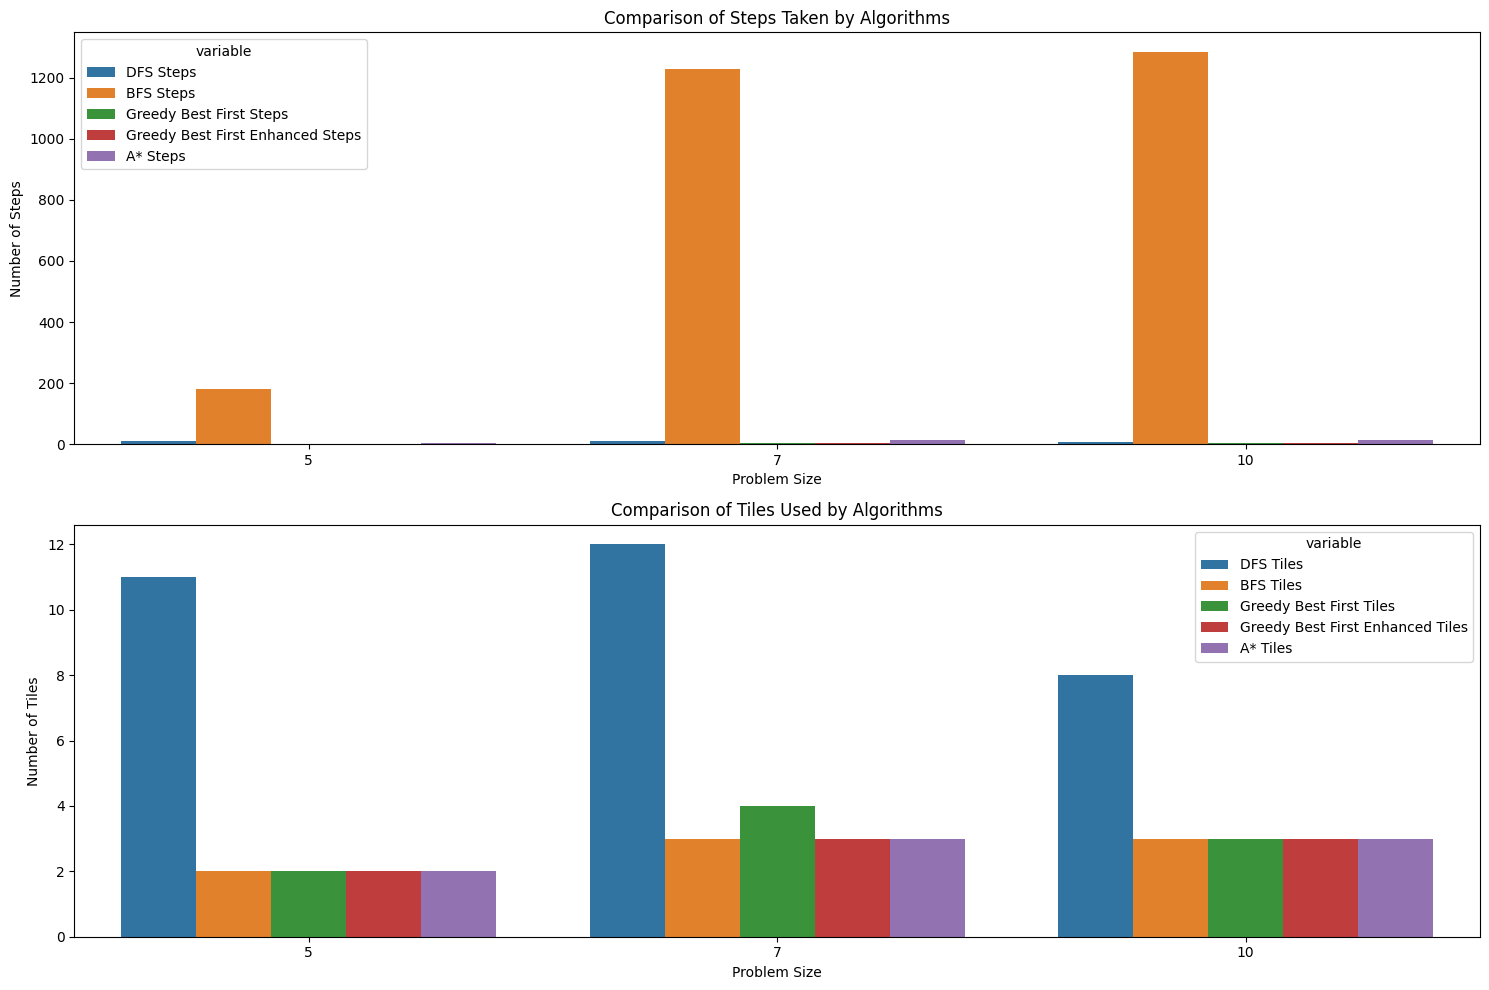

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a DataFrame from the provided data
data = {
    "Problem Size": [5, 7, 10],
    "Num Sets": [20, 20, 25],
    "DFS Steps": [11, 12, 8],
    "DFS Tiles": [11, 12, 8],
    "BFS Steps": [181, 1227, 1284],
    "BFS Tiles": [2, 3, 3],
    "Greedy Best First Steps": [2, 4, 3],
    "Greedy Best First Tiles": [2, 4, 3],
    "Greedy Best First Enhanced Steps": [2, 3, 3],
    "Greedy Best First Enhanced Tiles": [2, 3, 3],
    "A* Steps": [4, 14, 13],
    "A* Tiles": [2, 3, 3],
}

df = pd.DataFrame(data)

# Displaying the DataFrame
df

# Creating visualizations
plt.figure(figsize=(15, 10))

# Plotting steps taken by each algorithm
plt.subplot(2, 1, 1)
sns.barplot(x="Problem Size", y="value", hue="variable", data=df.melt(id_vars=["Problem Size", "Num Sets"], value_vars=["DFS Steps", "BFS Steps", "Greedy Best First Steps", "Greedy Best First Enhanced Steps", "A* Steps"]))
plt.title("Comparison of Steps Taken by Algorithms")
plt.ylabel("Number of Steps")
plt.xlabel("Problem Size")

# Plotting tiles used by each algorithm
plt.subplot(2, 1, 2)
sns.barplot(x="Problem Size", y="value", hue="variable", data=df.melt(id_vars=["Problem Size", "Num Sets"], value_vars=["DFS Tiles", "BFS Tiles", "Greedy Best First Tiles", "Greedy Best First Enhanced Tiles", "A* Tiles"]))
plt.title("Comparison of Tiles Used by Algorithms")
plt.ylabel("Number of Tiles")
plt.xlabel("Problem Size")

plt.tight_layout()
plt.show()



### General Observations
<b>DFS:</b> Consistently the least efficient in terms of tile usage, as it doesn't prioritize covering the most elements quickly.

<b>BFS:</b> Effective in minimizing tiles but at the cost of a higher number of steps, due to its exhaustive nature.

<b>Greedy Best First (Regular and Enhanced):</b> Both are efficient, especially in smaller problems. The enhanced heuristic shows its strength as problem complexity increases.

<b>A*:</b> Generally efficient in tile usage, balancing between goal-directed and exploratory search. It often takes more steps than the Greedy approach, likely due to its more comprehensive search strategy.
Conclusions

### Efficiency vs. Completeness:
While DFS and BFS are comprehensive, they aren't always the most efficient, especially in terms of tile usage.

<b>Heuristics Play a Key Role:</b> The effectiveness of the Greedy Best First and A* algorithms highlights the importance of a well-designed heuristic.

<b>Scalability:</b> The performance of each algorithm varies with problem size, indicating the need for different strategies depending on the scenario.

ga

In [91]:
def create_individual():
    """
    Creates an individual for the genetic algorithm population.

    An individual is represented as a binary array, where each element
    corresponds to a set in the set covering problem. A value of 1 means
    the set is included in the solution, and 0 means it is not.

    Returns:
        numpy.ndarray: A binary array representing an individual.
    """
    return np.random.randint(2, size=NUM_SETS)

def fitness(individual):
    """
    Calculates the fitness of an individual.

    Fitness is defined as the total number of elements covered by the selected
    sets minus the number of sets used. This encourages solutions that cover
    more elements with fewer sets.

    Args:
        individual (numpy.ndarray): The individual for which to calculate fitness.

    Returns:
        int: The fitness value of the individual.
    """
    covered_elements = np.array([False] * PROBLEM_SIZE)
    num_sets_used = np.sum(individual)

    for i, set_included in enumerate(individual):
        if set_included:
            covered_elements = np.logical_or(covered_elements, SETS[i])

    total_coverage = np.sum(covered_elements)
    return total_coverage - num_sets_used


def initialize_population(pop_size):
    """
    Initializes the population for the genetic algorithm.

    Args:
        pop_size (int): The size of the population to generate.

    Returns:
        list: A list of individuals forming the initial population.
    """
    return [create_individual() for _ in range(pop_size)]


def roulette_wheel_selection(population, fitnesses):
    """
    Selects individuals from the population based on roulette wheel selection.

    This method gives individuals a selection probability proportional to their
    fitness, favoring fitter individuals for reproduction.

    Args:
        population (list): The current population of individuals.
        fitnesses (list): The fitness values of the individuals in the population.

    Returns:
        list: Two selected individuals for crossover.
    """
    adjusted_fitnesses = [max(f, 0) for f in fitnesses]  # Ensure no negative fitness
    total_fitness = sum(adjusted_fitnesses)
    
    if total_fitness == 0:
        return np.random.choice(population, 2)  # Random selection if total fitness is 0

    selection_probs = [f / total_fitness for f in adjusted_fitnesses]
    chosen_indices = np.random.choice(len(population), 2, p=selection_probs)
    return [population[i] for i in chosen_indices]


def crossover(parent1, parent2):
    """
    Performs crossover between two parent individuals.

    This function uses single-point crossover, where a point is chosen randomly
    and the genetic information is exchanged between the parents from that point.

    Args:
        parent1 (numpy.ndarray): The first parent individual.
        parent2 (numpy.ndarray): The second parent individual.

    Returns:
        tuple: Two new individuals resulting from the crossover.
    """ 
    point = np.random.randint(NUM_SETS)
    child1 = np.concatenate([parent1[:point], parent2[point:]])
    child2 = np.concatenate([parent2[:point], parent1[point:]])
    return child1, child2

def mutate(individual, mutation_rate=0.01):
    """
    Performs mutation on an individual.

    Each gene (set inclusion/exclusion) in the individual has a chance of
    being flipped (included becomes excluded, and vice versa).

    Args:
        individual (numpy.ndarray): The individual to mutate.
        mutation_rate (float): The probability of each gene undergoing mutation.

    Returns:
        numpy.ndarray: The mutated individual.
    """
    for i in range(NUM_SETS):
        if np.random.rand() < mutation_rate:
            individual[i] = 1 - individual[i]
    return individual

def run_genetic_algorithm(pop_size, max_generations):
    """
    Runs the genetic algorithm.

    Args:
        pop_size (int): The size of the population.
        max_generations (int): The maximum number of generations to run the algorithm.

    Returns:
        numpy.ndarray: The best solution found by the genetic algorithm.
    """
    population = initialize_population(pop_size)
    for generation in range(max_generations):
        new_population = []
        fitnesses = [fitness(ind) for ind in population]

        for _ in range(len(population) // 2):
            parent1, parent2 = roulette_wheel_selection(population, fitnesses)
            child1, child2 = crossover(parent1, parent2)
            new_population.extend([mutate(child1), mutate(child2)])

        population = new_population

    # Return the best solution
    return max(population, key=fitness)

best_solution = run_genetic_algorithm(pop_size=100, max_generations=50)
print("Best solution:", best_solution)





Best solution: [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


In [95]:
coverage = np.array([False] * PROBLEM_SIZE)
for i, included in enumerate(best_solution):
    if included:
        coverage = np.logical_or(coverage, SETS[i])
all_covered = np.all(coverage)
all_covered

True